<img src="https://webna.ir/wp-content/uploads/2018/08/%D9%85%DA%A9%D8%AA%D8%A8-%D8%AE%D9%88%D9%86%D9%87.png" width=50% />

<div class="alert alert-block alert-success">
    <h1 align="center">Machine Learning in Python</h1>
    <h3 align="center">Project1</h3>
</div>

<img src = "https://www.eesc.europa.eu/sites/default/files/styles/large/public/images/shutterstock_1642888921.jpg?itok=P9-6YhGd" width=50%>

## Importing the libraries

In [1]:
import datetime

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MonthLocator

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

# turn off warnings for final notebook
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Load and Prepare Data

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gpreda/covid-world-vaccination-progress")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/covid-world-vaccination-progress


In [4]:
df = pd.read_csv(path + "/country_vaccinations.csv")

country_vac_manuf = pd.read_csv(path + "/country_vaccinations_by_manufacturer.csv")

## EDA

In [5]:
df.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,34.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,34.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
3,Afghanistan,AFG,2021-02-25,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,34.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
4,Afghanistan,AFG,2021-02-26,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,34.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/


In [6]:
df.shape

(86512, 15)

Our dataset have 31240 rows and 15 columns.

In [7]:
df.columns

Index(['country', 'iso_code', 'date', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated',
       'daily_vaccinations_raw', 'daily_vaccinations',
       'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'daily_vaccinations_per_million',
       'vaccines', 'source_name', 'source_website'],
      dtype='object')

The data (country vaccinations) contains the following information:

- **Country**- this is the country for which the vaccination information is provided;

- **Country ISO Code** - ISO code for the country;

- **Date** - date for the data entry; for some of the dates we have only the daily vaccinations, for others, only the (cumulative) total;

- **Total number of vaccinations** - this is the absolute number of total immunizations in the country;

- **Total number of people vaccinated** - a person, depending on the immunization scheme, will receive one or more (typically 2) vaccines; at a certain moment, the number of vaccination might be larger than the number of people;

- **Total number of people fully vaccinated** - this is the number of people that received the entire set of immunization according to the immunization scheme (typically 2); at a certain moment in time, there might be a certain number of people that received one vaccine and another number (smaller) of people that received all vaccines in the scheme;

- **Daily vaccinations (raw)** - for a certain data entry, the number of vaccination for that date/country;

- **Daily vaccinations** - for a certain data entry, the number of vaccination for that date/country;

- **Total vaccinations per hundred** - ratio (in percent) between vaccination number and total population up to the date in the country;

- **Total number of people vaccinated per hundred** - ratio (in percent) between population immunized and total population up to the date in the country;

- **Total number of people fully vaccinated per hundred** - ratio (in percent) between population fully immunized and total population up to the date in the country;

- **Number of vaccinations per day** - number of daily vaccination for that day and country;

- **Daily vaccinations per million** - ratio (in ppm) between vaccination number and total population for the current date in the country;

- **Vaccines used in the country** - total number of vaccines used in the country (up to date);

- **Source name** - source of the information (national authority, international organization, local organization etc.);

- **Source website** - website of the source of information;


There is a second file added recently (country vaccinations by manufacturer), with the following columns:

- Location - country;
- Date - date;
- Vaccine - vaccine type;
- Total number of vaccinations - total number of vaccinations / current time and vaccine type.

In [8]:
country_vac_manuf.head()

,location,date,vaccine,total_vaccinations
0,Argentina,2020-12-29,Moderna,2
1,Argentina,2020-12-29,Oxford/AstraZeneca,3
2,Argentina,2020-12-29,Sinopharm/Beijing,1
3,Argentina,2020-12-29,Sputnik V,20481
4,Argentina,2020-12-30,Moderna,2


In [9]:
country_vac_manuf["date"]= pd.to_datetime(country_vac_manuf["date"], format="%Y-%m-%d")

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86512 entries, 0 to 86511
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   country                              86512 non-null  object 
 1   iso_code                             86512 non-null  object 
 2   date                                 86512 non-null  object 
 3   total_vaccinations                   43607 non-null  float64
 4   people_vaccinated                    41294 non-null  float64
 5   people_fully_vaccinated              38802 non-null  float64
 6   daily_vaccinations_raw               35362 non-null  float64
 7   daily_vaccinations                   86213 non-null  float64
 8   total_vaccinations_per_hundred       43607 non-null  float64
 9   people_vaccinated_per_hundred        41294 non-null  float64
 10  people_fully_vaccinated_per_hundred  38802 non-null  float64
 11  daily_vaccinations_per_milli

In [11]:
print(df.isna().sum())

country                                    0
iso_code                                   0
date                                       0
total_vaccinations                     42905
people_vaccinated                      45218
people_fully_vaccinated                47710
daily_vaccinations_raw                 51150
daily_vaccinations                       299
total_vaccinations_per_hundred         42905
people_vaccinated_per_hundred          45218
people_fully_vaccinated_per_hundred    47710
daily_vaccinations_per_million           299
vaccines                                   0
source_name                                0
source_website                             0
dtype: int64


We have lots of missing values that we should handle.

In [12]:
df.duplicated().sum()

0

Our dataset does not have any duplicated rows.

In [13]:
df.country.nunique()

223

In [14]:
df.daily_vaccinations.value_counts()

daily_vaccinations
0.0         432
2.0         395
14.0        238
196.0       187
41369.0     182
           ... 
45344.0       1
82365.0       1
119386.0      1
156407.0      1
103751.0      1
Name: count, Length: 40516, dtype: int64

In [15]:
df.people_fully_vaccinated_per_hundred.value_counts()

people_fully_vaccinated_per_hundred
0.00     598
0.01     186
0.02     115
0.04      97
0.08      92
        ... 
82.84      1
83.00      1
83.02      1
84.10      1
23.26      1
Name: count, Length: 8772, dtype: int64

In [16]:
df.vaccines.value_counts()

vaccines
Johnson&Johnson, Moderna, Oxford/AstraZeneca, Pfizer/BioNTech                     7608
Moderna, Oxford/AstraZeneca, Pfizer/BioNTech                                      6263
Oxford/AstraZeneca                                                                6022
Oxford/AstraZeneca, Pfizer/BioNTech                                               4629
Johnson&Johnson, Moderna, Novavax, Oxford/AstraZeneca, Pfizer/BioNTech            3564
                                                                                  ... 
Johnson&Johnson, Oxford/AstraZeneca, Sinovac                                       312
Moderna, Oxford/AstraZeneca, Pfizer/BioNTech, Sinovac, Sputnik V                   311
Johnson&Johnson, Moderna                                                           251
Johnson&Johnson, Pfizer/BioNTech, Sinopharm/Beijing                                228
EpiVacCorona, Oxford/AstraZeneca, QazVac, Sinopharm/Beijing, Sputnik V, ZF2001     190
Name: count, Length: 84, dtype: in

In [17]:
country_vac_manuf.vaccine.value_counts()

vaccine
Pfizer/BioNTech       8888
Moderna               6641
Oxford/AstraZeneca    6633
Johnson&Johnson       5514
Sinovac               2413
Novavax               1692
Sinopharm/Beijing     1502
Sputnik V              977
CanSino                894
Covaxin                469
Name: count, dtype: int64

In [18]:
df.source_name.value_counts()

source_name
World Health Organization                            26822
Ministry of Health                                   15027
SPC Public Health Division                            4300
Pan American Health Organization                      3075
Africa Centres for Disease Control and Prevention     2780
                                                     ...  
Government of Aruba                                    366
National Council                                       357
Government of Zambia                                   350
Government of Saint Helena                              92
Government of the Falkland Islands                      67
Name: count, Length: 81, dtype: int64

In [19]:
df.source_website.value_counts()

source_website
https://covid19.who.int/                                                                                                                                25951
https://ais.paho.org/imm/IM_DosisAdmin-Vacunacion.asp                                                                                                    4677
https://stats.pacificdata.org/vis?tm=covid&pg=0&df[ds]=SPC2&df[id]=DF_COVID_VACCINATION&df[ag]=SPC&df[vs]=1.0                                            4382
https://africacdc.org/covid-19-vaccination/                                                                                                              2239
https://coronavirus.data.gov.uk/details/vaccinations                                                                                                     2215
                                                                                                                                                        ...  
https://salud.msp.gob.cu/actualizacio

In [20]:
df.total_vaccinations

0              0.0
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
86507    8691642.0
86508    8791728.0
86509    8845039.0
86510    8934360.0
86511    9039729.0
Name: total_vaccinations, Length: 86512, dtype: float64

In [21]:
df["date"]= pd.to_datetime(df["date"], format="%Y-%m-%d")

In [22]:
df["date"].head()

0   2021-02-22
1   2021-02-23
2   2021-02-24
3   2021-02-25
4   2021-02-26
Name: date, dtype: datetime64[ns]

In [23]:
df['Day'] = df['date'].dt.day
df['Month'] = df['date'].dt.month
df['Year'] = df['date'].dt.year

In [24]:
df.describe()

,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,Day,Month,Year
count,86512,4.360700e+04,4.129400e+04,3.880200e+04,3.536200e+04,8.621300e+04,43607.000000,41294.000000,38802.000000,86213.000000,86512.000000,86512.000000,86512.000000
mean,2021-09-01 17:09:45.907157504,4.592964e+07,1.770508e+07,1.413830e+07,2.705996e+05,1.313055e+05,80.188543,40.927317,35.523243,3257.049157,15.719357,6.165711,2021.199024
min,2020-12-02 00:00:00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2020.000000
25%,2021-05-27 00:00:00,5.264100e+05,3.494642e+05,2.439622e+05,4.668000e+03,9.000000e+02,16.050000,11.370000,7.020000,636.000000,8.000000,3.000000,2021.000000
50%,2021-09-04 00:00:00,3.590096e+06,2.187310e+06,1.722140e+06,2.530900e+04,7.343000e+03,67.520000,41.435000,31.750000,2050.000000,16.000000,6.000000,2021.000000
75%,2021-12-12 00:00:00,1.701230e+07,9.152520e+06,7.559870e+06,1.234925e+05,4.409800e+04,132.735000,67.910000,62.080000,4682.000000,23.000000,9.000000,2021.000000
max,2022-03-29 00:00:00,3.263129e+09,1.275541e+09,1.240777e+09,2.474100e+07,2.242429e+07,345.370000,124.760000,122.370000,117497.000000,31.000000,12.000000,2022.000000
std,NaN,2.246004e+08,7.078731e+07,5.713920e+07,1.212427e+06,7.682388e+05,67.913577,29.290759,28.376252,3934.312440,8.743045,3.547866,0.408767


## Strorytelling - Visualization

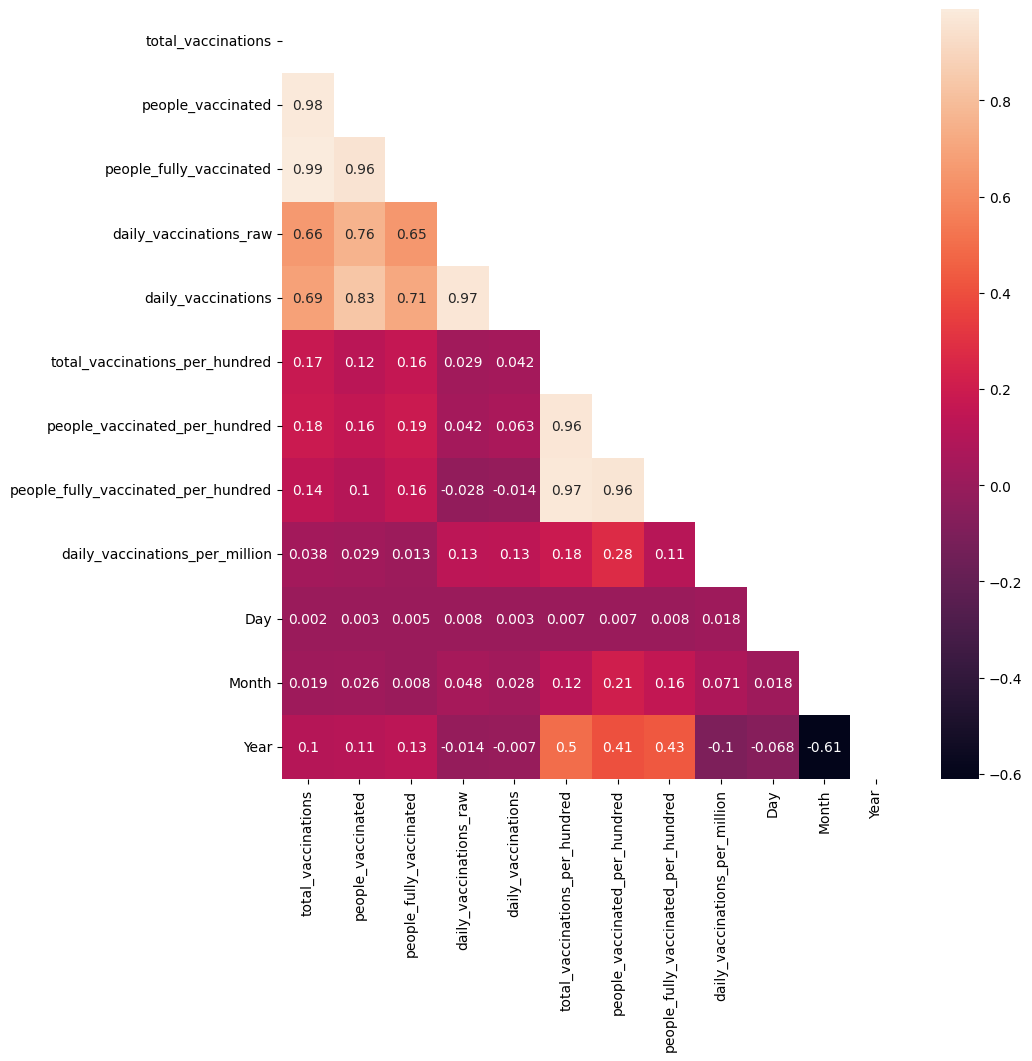

In [25]:
numeric_cols = ['total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated',
       'daily_vaccinations_raw', 'daily_vaccinations',
       'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'daily_vaccinations_per_million', 'Day', 'Month', 'Year']

fig = plt.figure(figsize=(10,10))

matrix = np.triu(df[numeric_cols].corr())
sns.heatmap(df[numeric_cols].corr().round(3), mask=matrix, annot=True)
plt.show()

We can see from the heatmap that `people_vaccinated` and `people_fully_vaccinated` are highly correlated with `total_vaccinations`.Because `total_vaccinations` is the sum of other two columns.

- `daily_vaccinations` and `daily_vaccinations_raw`are highly correlated.

- `total_vaccinations_per_hundred`, `people_vaccinated_per_hundred` and `people_fully_vaccinated_per_hundred` are highly correlated.


['country', 'iso_code', 'date', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated',
       'daily_vaccinations_raw', 'daily_vaccinations',
       'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'daily_vaccinations_per_million',
       'vaccines', 'source_name', 'source_website', 'Day', 'Month', 'Year']

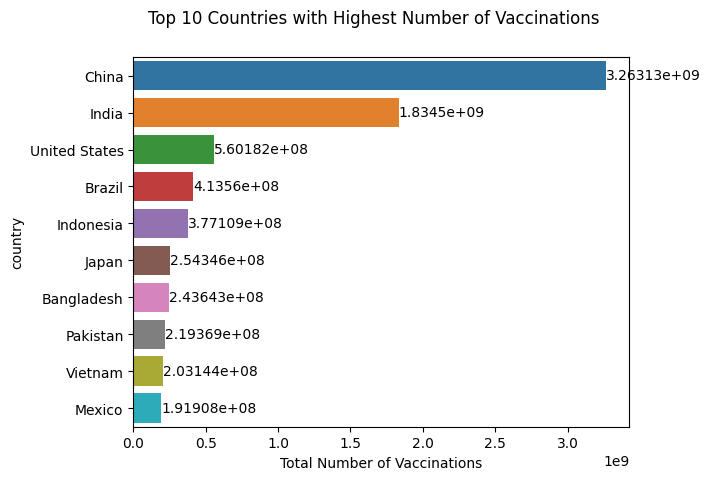

In [26]:
#fig = plt.figure(figsize=(8,4))

g =df.groupby('country')['total_vaccinations'].max().sort_values(ascending = False)[:10]

chart = sns.barplot(y=g.index, x= g.values) #boxplot barplot
chart.bar_label(chart.containers[0])
plt.xlabel('Total Number of Vaccinations')

plt.suptitle('Top 10 Countries with Highest Number of Vaccinations')


plt.show()

We can see from the bar plot that China, India and US has the highest total number of vaccinations.

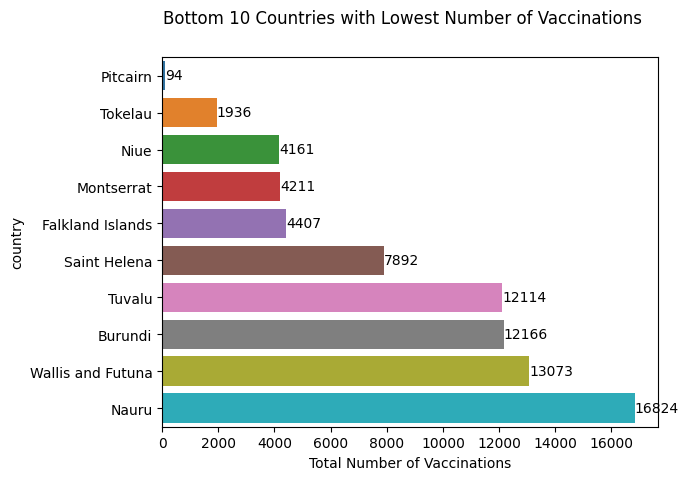

In [27]:
g =df.groupby('country')['total_vaccinations'].max().sort_values(ascending = True)[:10]

chart = sns.barplot(y=g.index, x= g.values) #boxplot barplot
chart.bar_label(chart.containers[0])
plt.xlabel('Total Number of Vaccinations')

plt.suptitle('Bottom 10 Countries with Lowest Number of Vaccinations')

plt.show()

The bar plot above shows that Pitcairn Islands has the lowest total number of vaccinations(94).

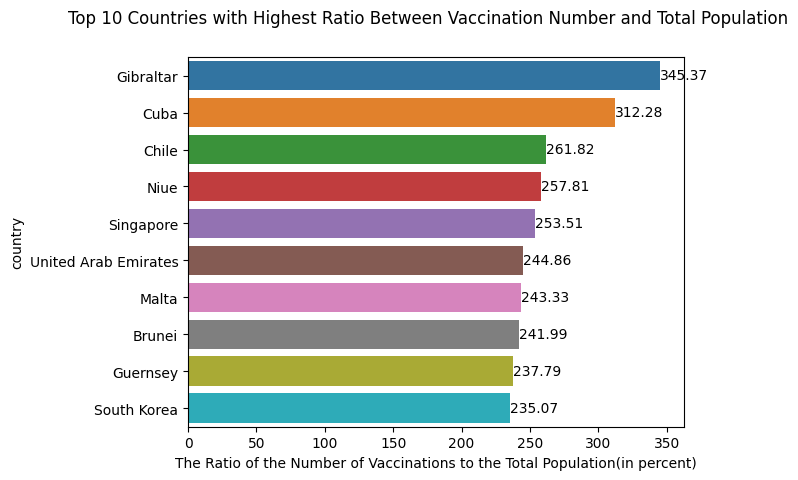

In [28]:
g =df.groupby('country')['total_vaccinations_per_hundred'].max().sort_values(ascending = False)[:10]

chart = sns.barplot(y=g.index, x= g.values) #boxplot barplot
chart.bar_label(chart.containers[0])
plt.xlabel('The Ratio of the Number of Vaccinations to the Total Population(in percent)')

plt.suptitle('Top 10 Countries with Highest Ratio Between Vaccination Number and Total Population')

plt.show()

Bar plot shows that `Gibraltar` has the highest ratio (in percent) between vaccination number and total population.After that `Cuba` and `Chile` have the highest ratio of corona vaccinations to the population and are in the second and third ranks respectively.

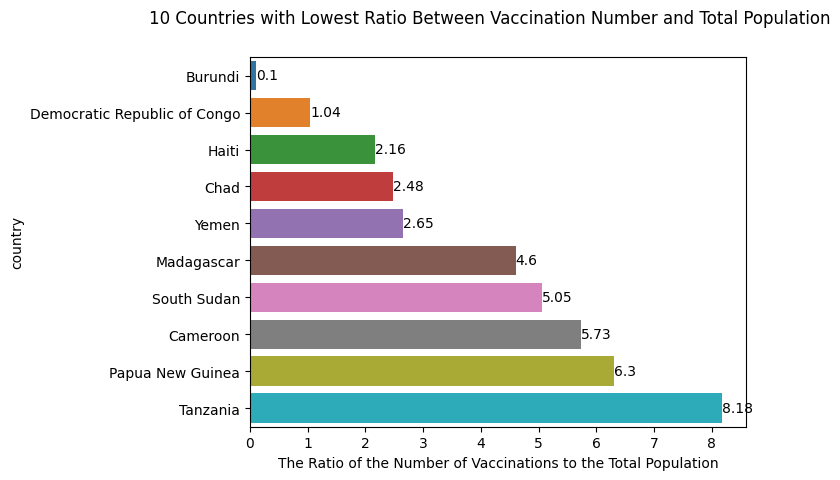

In [29]:
g =df.groupby('country')['total_vaccinations_per_hundred'].max().sort_values(ascending = True)[:10]

chart = sns.barplot(y=g.index, x= g.values) #boxplot barplot
chart.bar_label(chart.containers[0])
plt.xlabel('The Ratio of the Number of Vaccinations to the Total Population')

plt.suptitle('10 Countries with Lowest Ratio Between Vaccination Number and Total Population')

plt.show()

In [30]:
print(list(g.index))

['Burundi', 'Democratic Republic of Congo', 'Haiti', 'Chad', 'Yemen', 'Madagascar', 'South Sudan', 'Cameroon', 'Papua New Guinea', 'Tanzania']


From the above chart we can see that most of the countries with low ratio of corona vaccinations to the population are located in Africa.`Burundi` has the lowest percentage of vaccinations(0.1 percent).

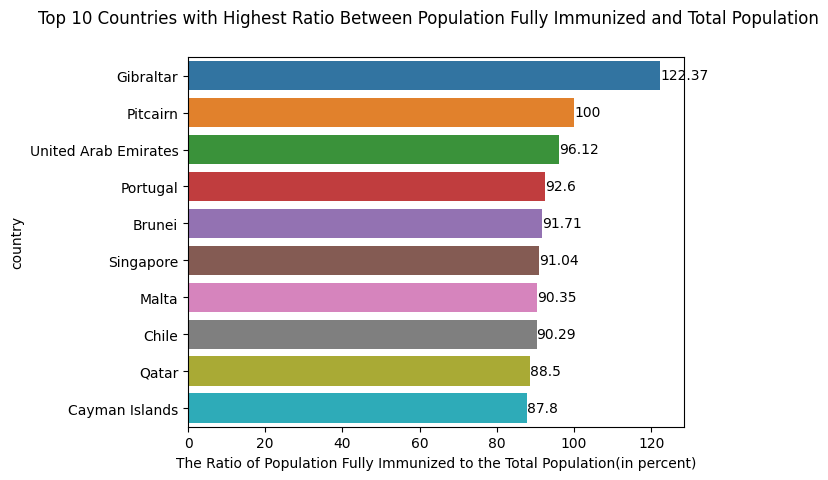

In [31]:
g =df.groupby('country')['people_fully_vaccinated_per_hundred'].max().sort_values(ascending = False)[:10]

chart = sns.barplot(y=g.index, x= g.values) #boxplot barplot
chart.bar_label(chart.containers[0])
plt.xlabel('The Ratio of Population Fully Immunized to the Total Population(in percent)')

plt.suptitle('Top 10 Countries with Highest Ratio Between Population Fully Immunized and Total Population')

plt.show()

The above chart shows that `Burundi` has the highest ratio between population fully immunized and total population.

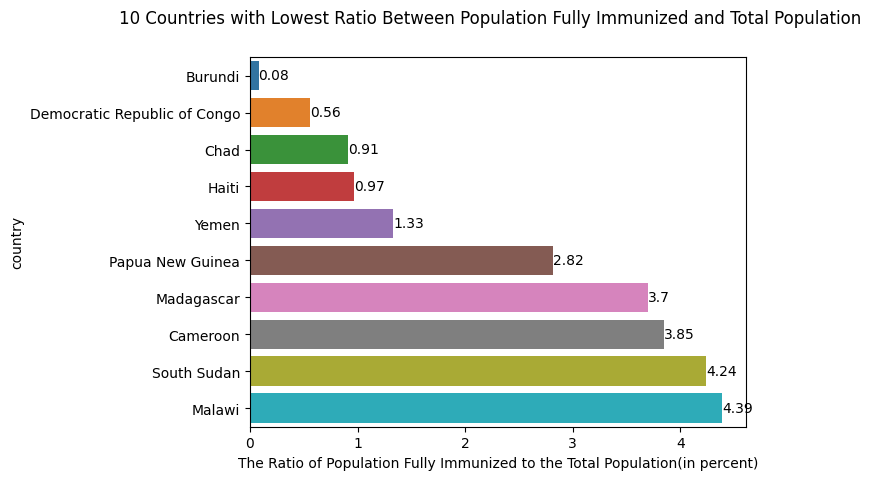

In [32]:
g =df.groupby('country')['people_fully_vaccinated_per_hundred'].max().sort_values(ascending = True)[:10]

chart = sns.barplot(y=g.index, x= g.values) #boxplot barplot
chart.bar_label(chart.containers[0])
plt.xlabel('The Ratio of Population Fully Immunized to the Total Population(in percent)')

plt.suptitle('10 Countries with Lowest Ratio Between Population Fully Immunized and Total Population')

plt.show()

The bar graph above shows that `Burundi` has the lowest percentage of population fully immunized.Again most of the countries with low ratio of population fully immunized to total population are located in Africa.

In [71]:
group =df.groupby('country')['total_vaccinations'].max().sort_values(ascending = False)[:3]

new =df.copy()

new = new[new.country.isin(list(group.index))]

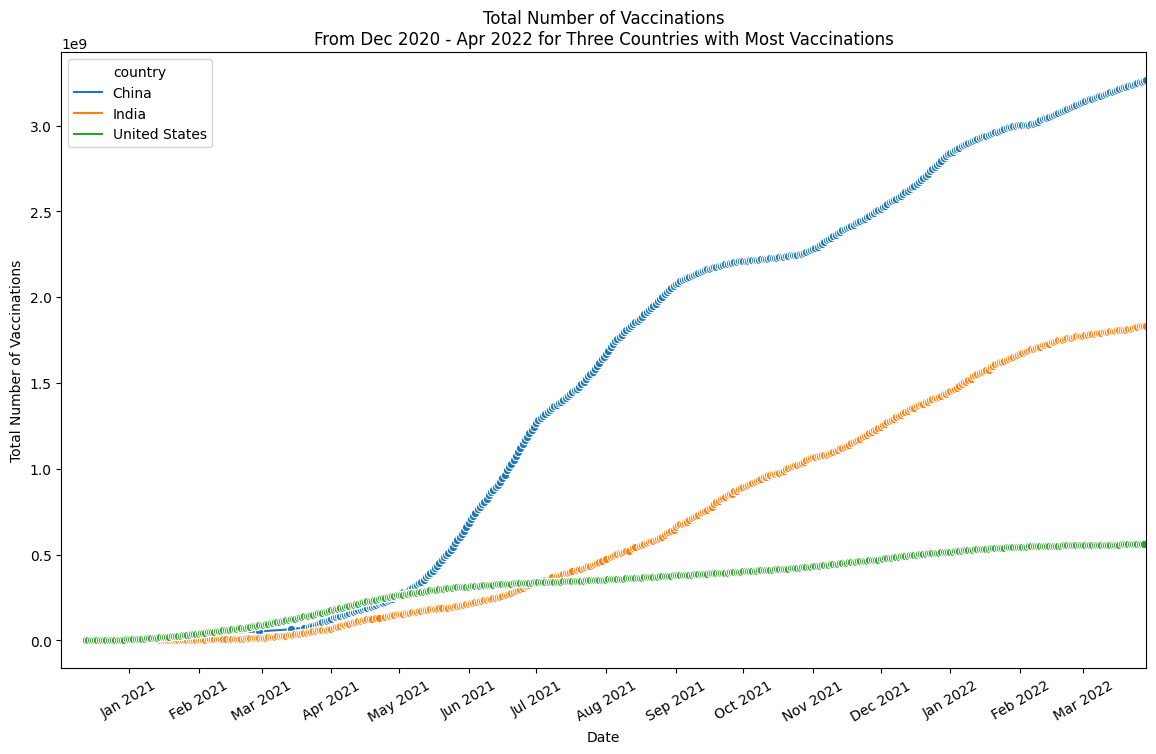

In [68]:
fig, ax = plt.subplots(figsize=(14, 8))  

sns.lineplot(data = new
                ,x = 'date'
                ,y = 'total_vaccinations'
                ,hue ='country'
                ,ci = None
                ,marker='o'
           )

plt.xlim(df.date.min(), df.date.max())

# Create custom ticks using matplotlib date tick locator and formatter
loc = MonthLocator(interval=1)
ax.xaxis.set_major_locator(loc)

ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))

plt.xlabel('Date')
plt.ylabel('Total Number of Vaccinations')
plt.title("Total Number of Vaccinations\nFrom Dec 2020 - Apr 2022 for Three Countries with Most Vaccinations")
plt.xticks(rotation=30)

plt.show()

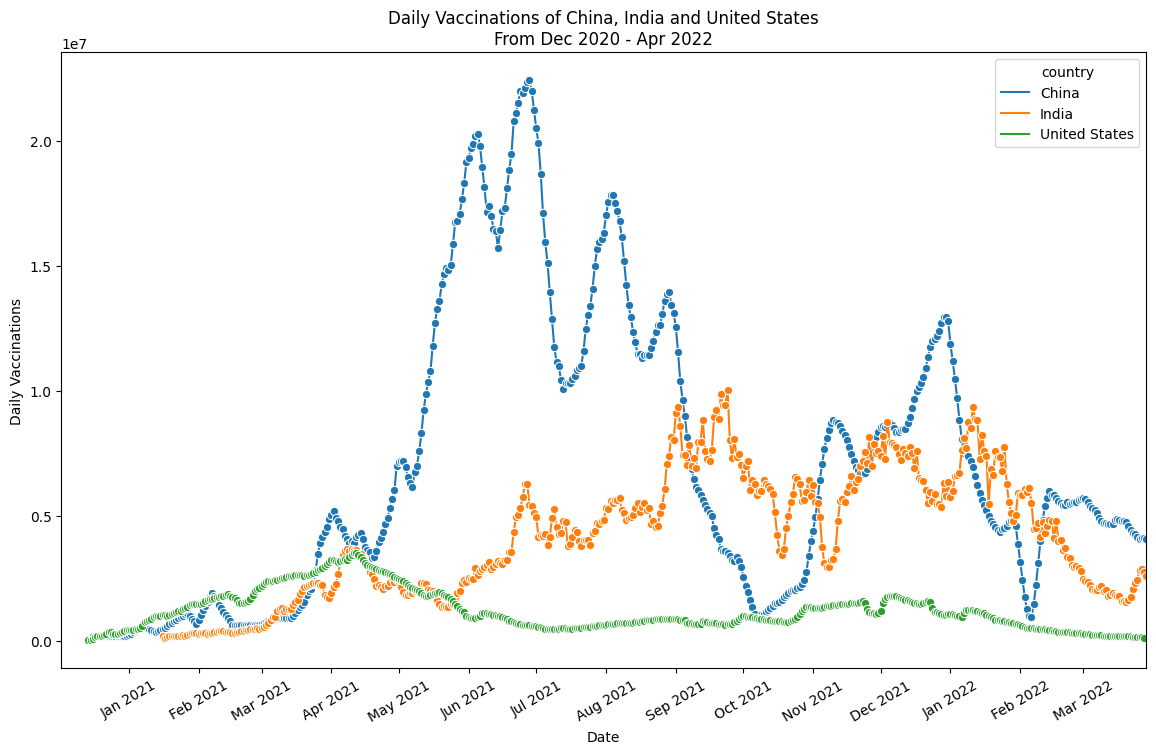

In [73]:
fig, ax = plt.subplots(figsize=(14, 8))  

sns.lineplot(data = new
                ,x = 'date'
                ,y = 'daily_vaccinations'
                ,hue ='country'
                ,ci = None
                ,marker='o'
           )

plt.xlim(df.date.min(), df.date.max())

# Create custom ticks using matplotlib date tick locator and formatter
loc = MonthLocator(interval=1)
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))

plt.xlabel('Date')
plt.ylabel('Daily Vaccinations')
plt.title("Daily Vaccinations of China, India and United States\nFrom Dec 2020 - Apr 2022")
plt.xticks(rotation=30)

plt.show()

In [74]:
group =df.groupby('country')['total_vaccinations_per_hundred'].max().sort_values(ascending = False)[:5]

new =df.copy()

new = new[new.country.isin(list(group.index))]

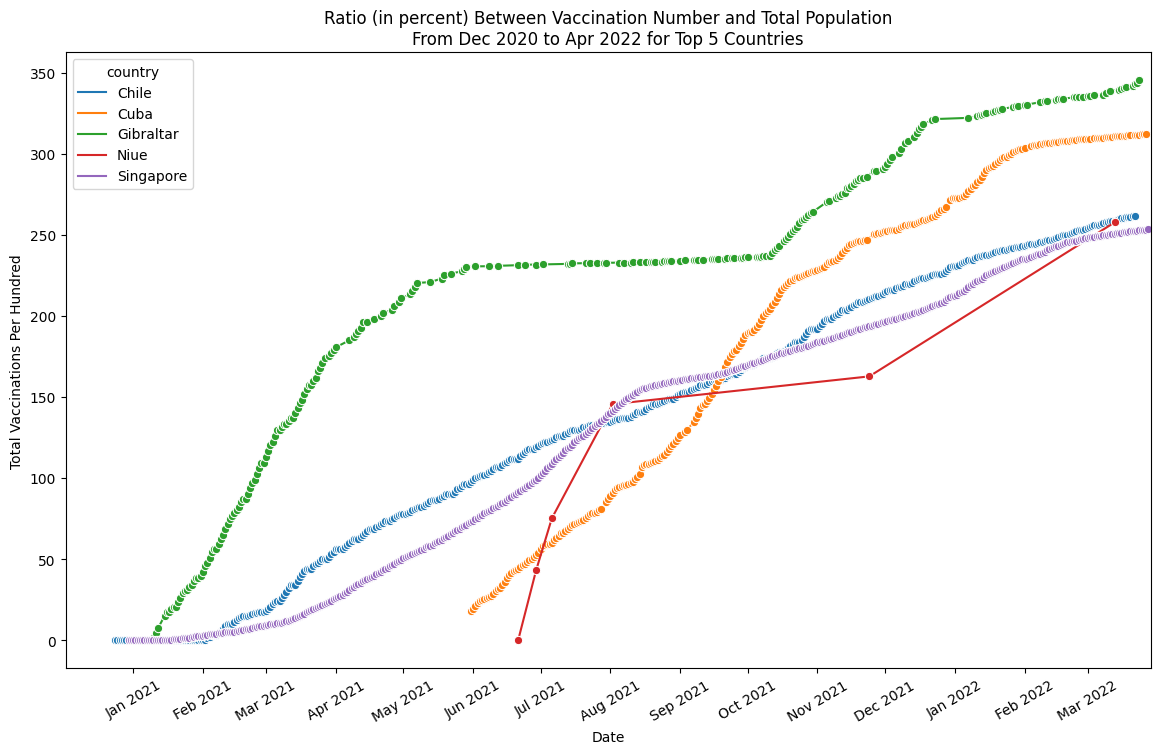

In [75]:
fig, ax = plt.subplots(figsize=(14, 8))  

sns.lineplot(data = new
                ,x = 'date'
                ,y = 'total_vaccinations_per_hundred'
                ,hue ='country'
                ,ci = None
                ,marker='o'
           )

plt.xlim(df.date.min(), df.date.max())

# Create custom ticks using matplotlib date tick locator and formatter
loc = MonthLocator(interval=1)
ax.xaxis.set_major_locator(loc)

ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))

plt.xlabel('Date')
plt.ylabel('Total Vaccinations Per Hundred')
plt.title("Ratio (in percent) Between Vaccination Number and Total Population\nFrom Dec 2020 to Apr 2022 for Top 5 Countries")
plt.xticks(rotation=30)

plt.show()

In [76]:
group =df.groupby('country')['people_fully_vaccinated_per_hundred'].max().sort_values(ascending = False)[:5]

new =df.copy()

new = new[new.country.isin(list(group.index))]

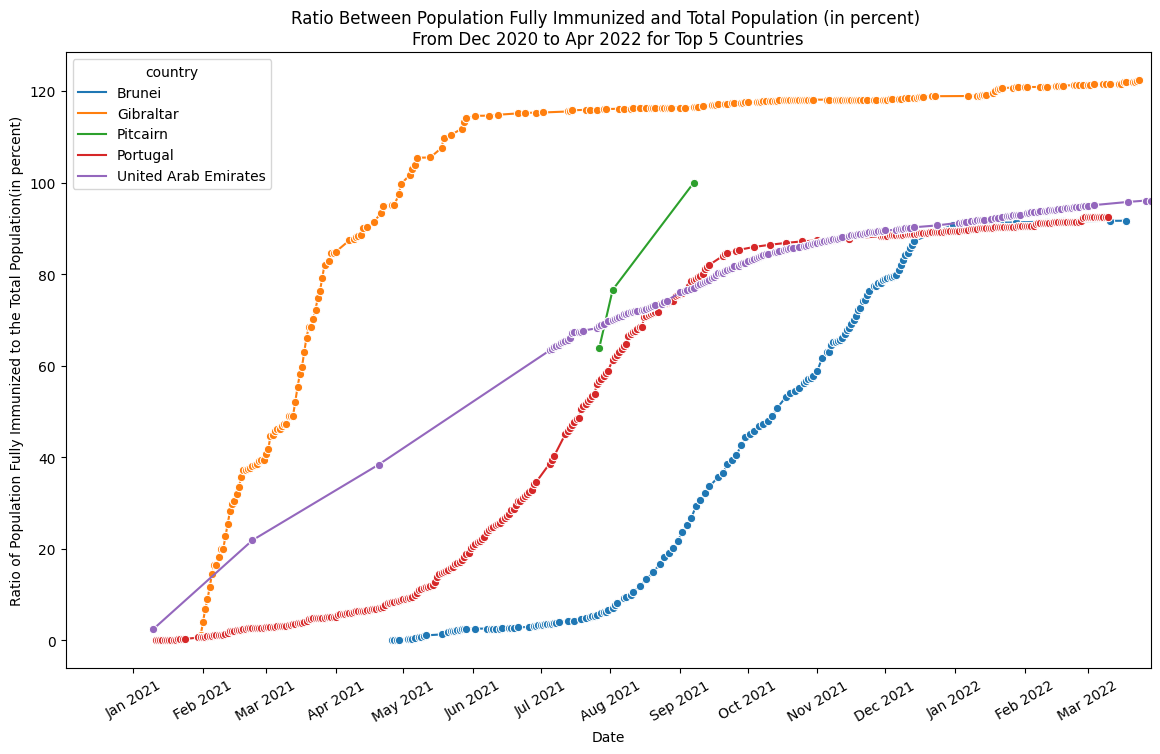

In [77]:
fig, ax = plt.subplots(figsize=(14, 8))  

sns.lineplot(data = new
                ,x = 'date'
                ,y = 'people_fully_vaccinated_per_hundred'
                ,hue ='country'
                ,ci = None
                ,marker='o'
           )

plt.xticks(rotation=30)

plt.xlim(df.date.min(), df.date.max())

# Create custom ticks using matplotlib date tick locator and formatter
loc = MonthLocator(interval=1)
ax.xaxis.set_major_locator(loc)

ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))

plt.xlabel('Date')
plt.ylabel('Ratio of Population Fully Immunized to the Total Population(in percent)')
plt.title("Ratio Between Population Fully Immunized and Total Population (in percent) \nFrom Dec 2020 to Apr 2022 for Top 5 Countries")

plt.show()

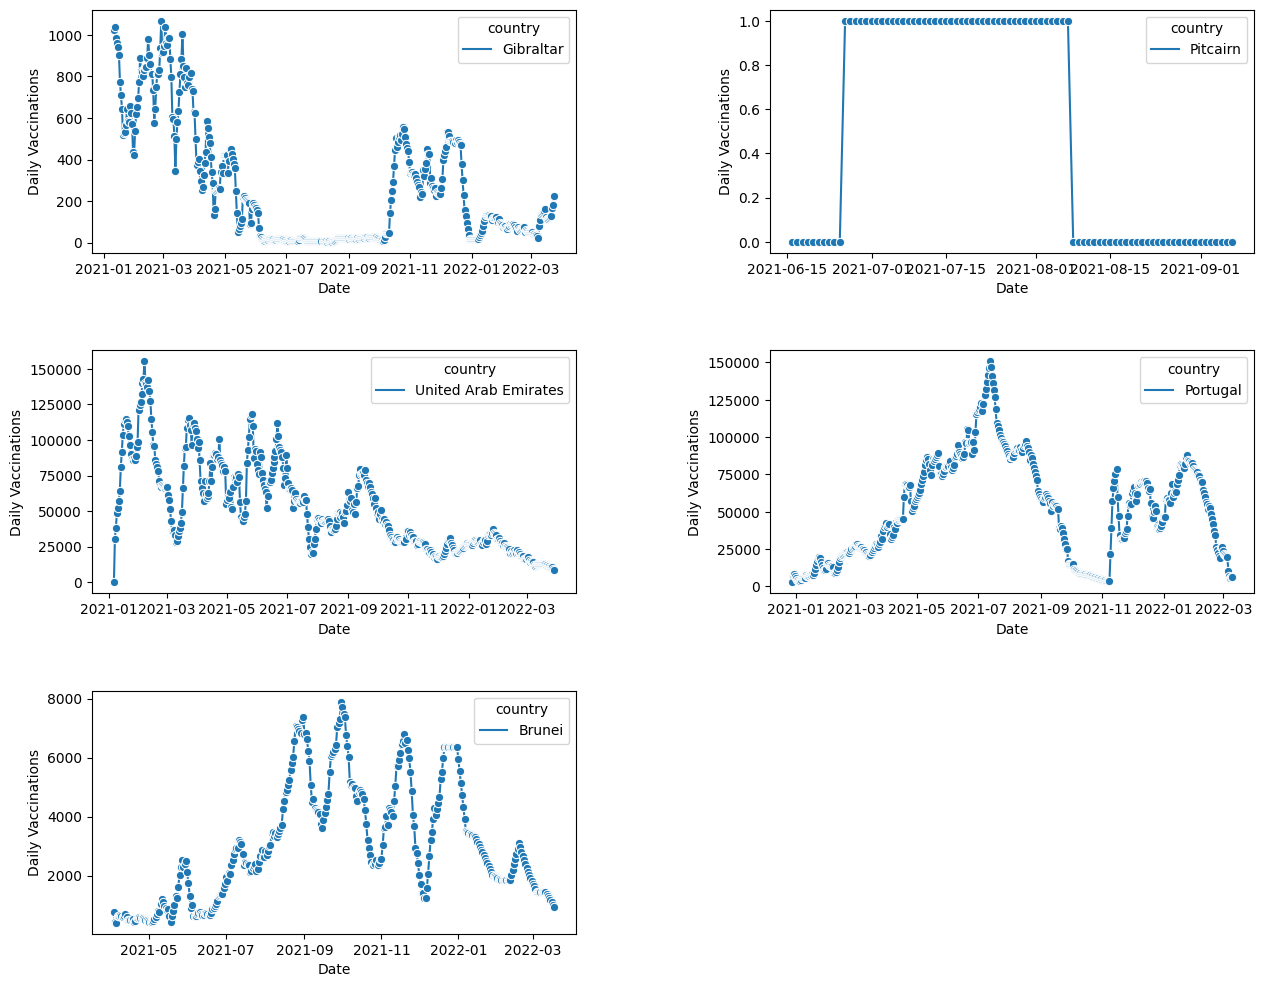

In [78]:
countries = list(group.index)
size = len(countries)

fig = plt.figure(figsize = (15, 12))

plt.subplots_adjust(wspace=0.4,
                    hspace=0.4)

for i in range(0,size):
    plt.subplot(3, 2, i+1)
    plt.xlabel('Date')
    plt.ylabel('Daily Vaccinations')
    sns.lineplot(data = new[new.country == countries[i]]
                ,x = 'date'
                ,y = 'daily_vaccinations'
                ,hue ='country'
                ,ci = None
                ,marker='o')

plt.show()

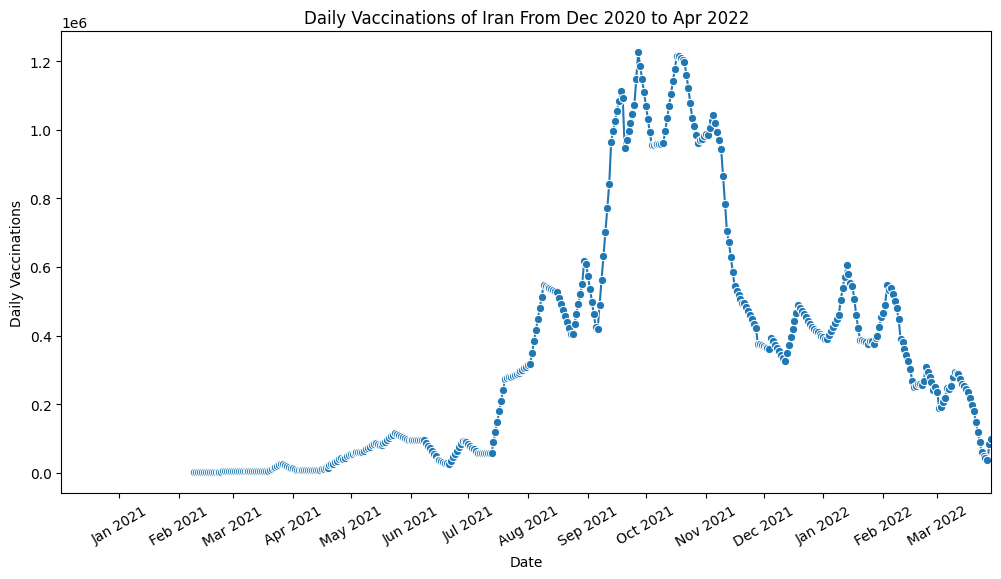

In [79]:
fig, ax = plt.subplots(figsize=(12, 6))  

sns.lineplot(data = df[df.country == "Iran"]
                ,x = 'date'
                ,y = 'daily_vaccinations'
                ,ci = None
                ,marker='o'
           )

plt.xticks(rotation=30)

plt.xlim(df.date.min(), df.date.max())

# Create custom ticks using matplotlib date tick locator and formatter
loc = MonthLocator(interval=1)
ax.xaxis.set_major_locator(loc)

ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))

plt.xlabel('Date')
plt.ylabel('Daily Vaccinations')
plt.title("Daily Vaccinations of Iran From Dec 2020 to Apr 2022")

plt.show()

We can see from the graph that Iran's vaccinations began in February 2021 and the number of Iran's daily vaccinations peaked at 1225502 in September 2021.

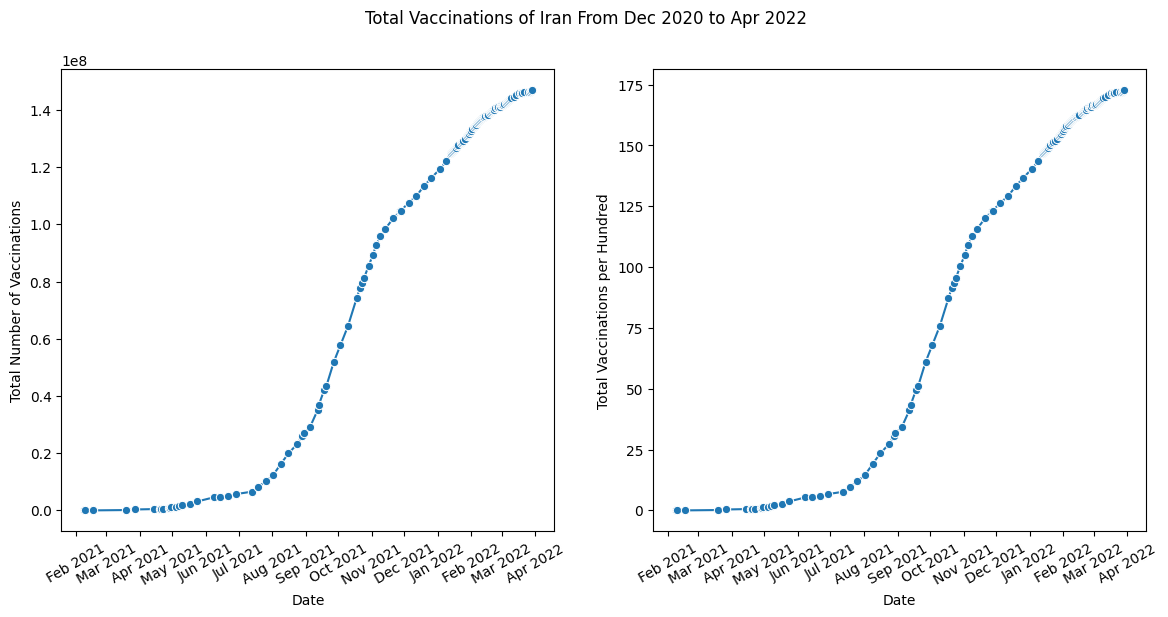

In [80]:
fig, ax = plt.subplots(1,2, figsize=(14, 6))  

sns.lineplot(ax = ax[0], data = df[df.country == "Iran"]
                ,x = 'date'
                ,y = 'total_vaccinations'
                ,ci = None
                ,marker='o'
           )

# Create custom ticks using matplotlib date tick locator and formatter
loc = MonthLocator(interval=1)
ax[0].xaxis.set_major_locator(loc)

ax[0].xaxis.set_major_formatter(DateFormatter('%b %Y'))

ax[0].set_xlabel('Date')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=30)

ax[0].set_ylabel('Total Number of Vaccinations')

#axs[0].set_title("also unrelated")

sns.lineplot(ax = ax[1], data = df[df.country == "Iran"]
                ,x = 'date'
                ,y = 'total_vaccinations_per_hundred'
                ,ci = None
                ,marker='o'
           )

# Create custom ticks using matplotlib date tick locator and formatter
ax[1].xaxis.set_major_locator(loc)

ax[1].xaxis.set_major_formatter(DateFormatter('%b %Y'))

ax[1].set_xlabel('Date')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=30)
ax[1].set_ylabel('Total Vaccinations per Hundred')


plt.suptitle("Total Vaccinations of Iran From Dec 2020 to Apr 2022")

plt.show()

The above plot shows that Iran's total number of vaccinations reached to 150 millions in April 2022.We can see that there are multiple gaps between the injections of the Covid-19 vaccines in Iran.

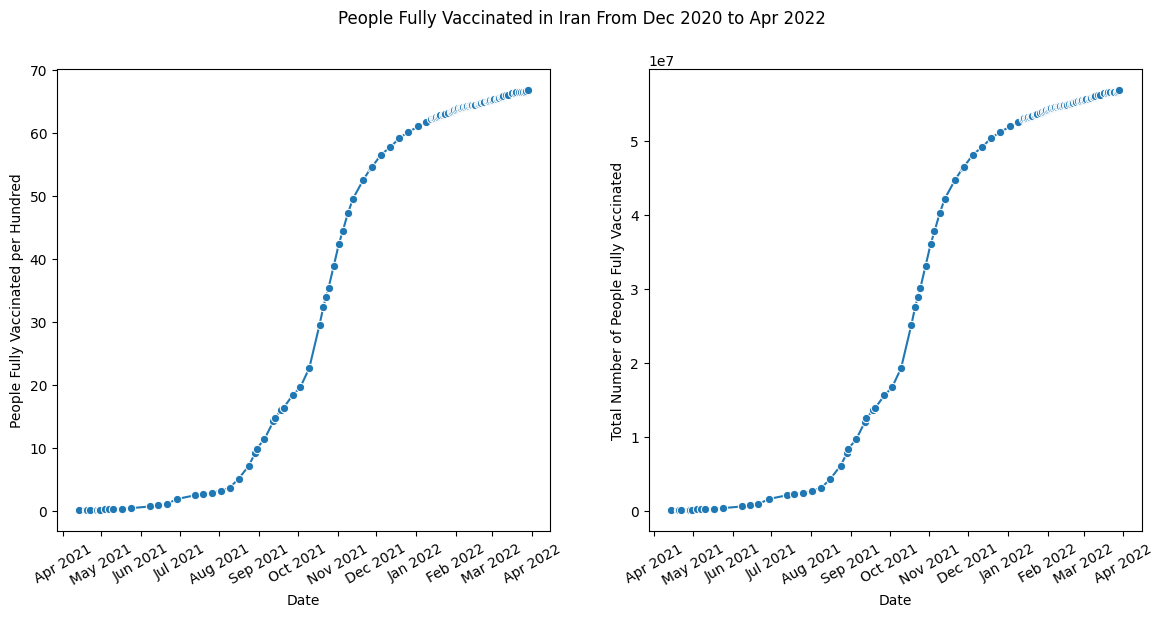

In [81]:
fig, ax = plt.subplots(1,2, figsize=(14, 6))  

sns.lineplot(ax = ax[0], data = df[df.country == "Iran"]
                ,x = 'date'
                ,y = 'people_fully_vaccinated_per_hundred'
                ,ci = None
                ,marker='o'
           )

# Create custom ticks using matplotlib date tick locator and formatter
loc = MonthLocator(interval=1)
ax[0].xaxis.set_major_locator(loc)

ax[0].xaxis.set_major_formatter(DateFormatter('%b %Y'))

ax[0].set_xlabel('Date')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=30)

ax[0].set_ylabel('People Fully Vaccinated per Hundred')

sns.lineplot(ax = ax[1], data = df[df.country == "Iran"]
                ,x = 'date'
                ,y = 'people_fully_vaccinated'
                ,ci = None
                ,marker='o'
           )

# Create custom ticks using matplotlib date tick locator and formatter
ax[1].xaxis.set_major_locator(loc)

ax[1].xaxis.set_major_formatter(DateFormatter('%b %Y'))

ax[1].set_xlabel('Date')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=30)

ax[1].set_ylabel('Total Number of People Fully Vaccinated')


plt.suptitle("People Fully Vaccinated in Iran From Dec 2020 to Apr 2022")

plt.show()

We can see that during this period only 67 percent of Iranians were fully vaccinated.

In [82]:
df[df.country == "Iran"].describe()

,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,Day,Month,Year
count,415,1.170000e+02,1.170000e+02,1.130000e+02,5.400000e+01,4.140000e+02,117.000000,117.000000,113.000000,414.000000,415.000000,415.000000,415.000000
mean,2021-09-02 23:59:59.999999744,9.140852e+07,4.465561e+07,3.812138e+07,3.528757e+05,3.535194e+05,107.503419,52.518547,44.833186,4157.630435,15.785542,6.050602,2021.212048
min,2021-02-08 00:00:00,0.000000e+00,0.000000e+00,1.006910e+05,3.000000e+03,8.750000e+02,0.000000,0.000000,0.120000,10.000000,1.000000,1.000000,2021.000000
25%,2021-05-22 12:00:00,2.705725e+07,1.946786e+07,1.362087e+07,2.142610e+05,5.801500e+04,31.820000,22.900000,16.020000,682.000000,8.000000,3.000000,2021.000000
50%,2021-09-03 00:00:00,1.255600e+08,6.032111e+07,5.325870e+07,3.262555e+05,2.914715e+05,147.670000,70.940000,62.640000,3428.000000,16.000000,6.000000,2021.000000
75%,2021-12-15 12:00:00,1.383574e+08,6.194901e+07,5.504239e+07,4.085740e+05,4.954790e+05,162.720000,72.860000,64.730000,5827.000000,23.000000,9.000000,2021.000000
max,2022-03-29 00:00:00,1.467926e+08,6.387282e+07,5.681006e+07,1.706088e+06,1.225502e+06,172.640000,75.120000,66.810000,14413.000000,31.000000,12.000000,2022.000000
std,NaN,5.676887e+07,2.460955e+07,2.253170e+07,2.530016e+05,3.420735e+05,66.764386,28.942260,26.498743,4023.045186,8.676125,3.487707,0.409252


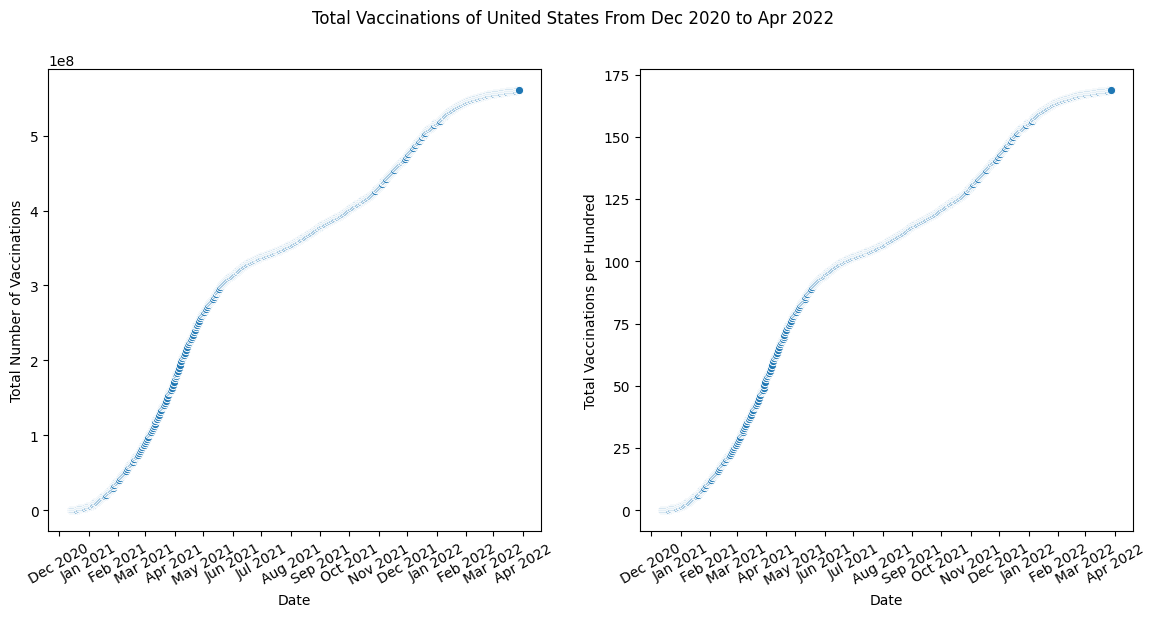

In [83]:
fig, ax = plt.subplots(1,2, figsize=(14, 6))  

sns.lineplot(ax = ax[0], data = df[df.country == "United States"]
                ,x = 'date'
                ,y = 'total_vaccinations'
                ,ci = None
                ,marker='o'
           )

# Create custom ticks using matplotlib date tick locator and formatter
loc = MonthLocator(interval=1)
ax[0].xaxis.set_major_locator(loc)

ax[0].xaxis.set_major_formatter(DateFormatter('%b %Y'))

ax[0].set_xlabel('Date')
ax[0].set_ylabel('Total Number of Vaccinations')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=30)

#axs[0].set_title("also unrelated")

sns.lineplot(ax = ax[1], data = df[df.country == "United States"]
                ,x = 'date'
                ,y = 'total_vaccinations_per_hundred'
                ,ci = None
                ,marker='o'
           )

# Create custom ticks using matplotlib date tick locator and formatter
ax[1].xaxis.set_major_locator(loc)

ax[1].xaxis.set_major_formatter(DateFormatter('%b %Y'))

ax[1].set_xlabel('Date')
ax[1].set_ylabel('Total Vaccinations per Hundred')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=30)

plt.suptitle("Total Vaccinations of United States From Dec 2020 to Apr 2022")

plt.show()

We can see from the above plot that vaccinations in the United States began in December of 2020 and in July 2021 total population of USA were vaccinated.

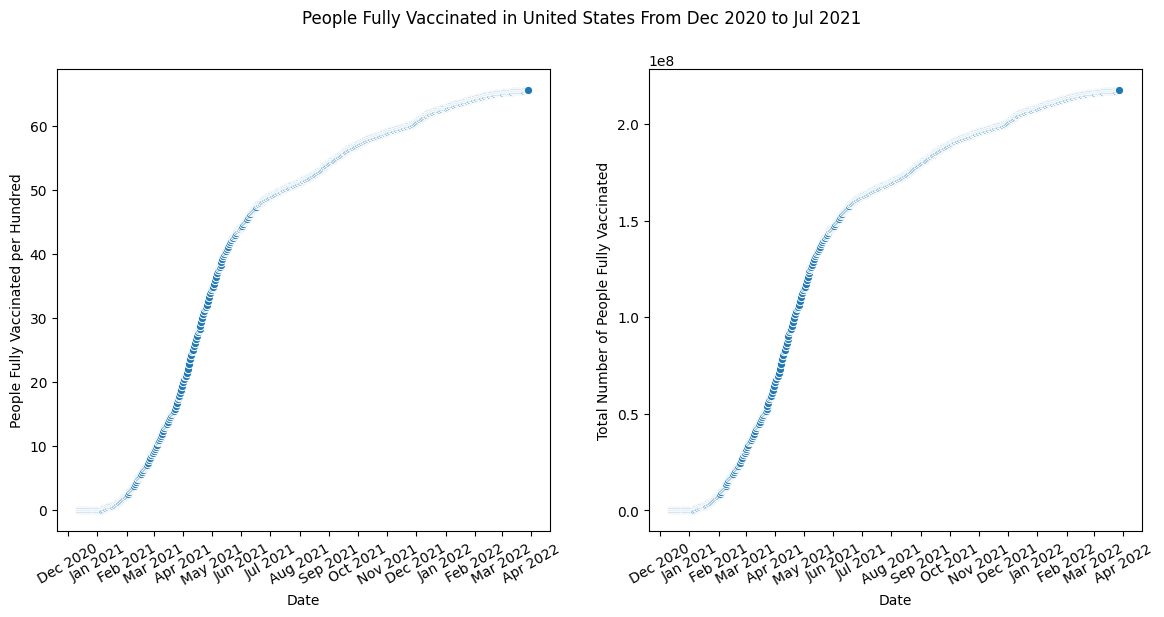

In [84]:
fig, ax = plt.subplots(1,2, figsize=(14, 6))  

sns.lineplot(ax = ax[0], data = df[df.country == "United States"]
                ,x = 'date'
                ,y = 'people_fully_vaccinated_per_hundred'
                ,ci = None
                ,marker='o'
           )

# Create custom ticks using matplotlib date tick locator and formatter
loc = MonthLocator(interval=1)
ax[0].xaxis.set_major_locator(loc)

ax[0].xaxis.set_major_formatter(DateFormatter('%b %Y'))

ax[0].set_xlabel('Date')
ax[0].set_ylabel('People Fully Vaccinated per Hundred')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=30)

sns.lineplot(ax = ax[1], data = df[df.country == "United States"]
                ,x = 'date'
                ,y = 'people_fully_vaccinated'
                ,ci = None
                ,marker='o'
           )

# Create custom ticks using matplotlib date tick locator and formatter
ax[1].xaxis.set_major_locator(loc)

ax[1].xaxis.set_major_formatter(DateFormatter('%b %Y'))

ax[1].set_xlabel('Date')
ax[1].set_ylabel('Total Number of People Fully Vaccinated')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=30)

plt.suptitle("People Fully Vaccinated in United States From Dec 2020 to Jul 2021")

plt.show()

The line graph shows that from December 2020 to July 2021 near half of US population(160 millions) were fully vaccinated.

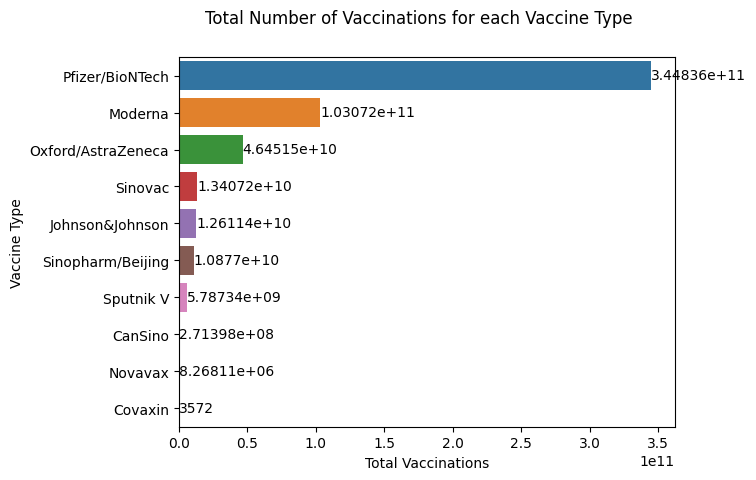

In [85]:
g = country_vac_manuf.groupby('vaccine')['total_vaccinations'].sum().sort_values(ascending = False)[:10]

chart = sns.barplot(y=g.index, x= g.values) #boxplot barplot
chart.bar_label(chart.containers[0])

plt.xlabel('Total Vaccinations')
plt.ylabel('Vaccine Type')

plt.suptitle('Total Number of Vaccinations for each Vaccine Type')

plt.show()

The bar plot shows that `Pfizer/BioNTech` is the most administered vaccine with 344 millions of total vaccinations.After that `Moderna` and `Oxford/AstraZeneca` are on second and third place.

`Covaxin` is the least administered vaccine.

In [86]:
country_vac_manuf.vaccine.unique()

array(['Moderna', 'Oxford/AstraZeneca', 'Sinopharm/Beijing', 'Sputnik V',
       'CanSino', 'Pfizer/BioNTech', 'Johnson&Johnson', 'Novavax',
       'Sinovac', 'Covaxin'], dtype=object)

In [87]:
country_vac_manuf.location.unique()

array(['Argentina', 'Austria', 'Belgium', 'Bulgaria', 'Chile', 'Croatia',
       'Cyprus', 'Czechia', 'Denmark', 'Ecuador', 'Estonia', 'Finland',
       'France', 'Germany', 'Hong Kong', 'Hungary', 'Iceland', 'Ireland',
       'Italy', 'Japan', 'Latvia', 'Liechtenstein', 'Lithuania',
       'Luxembourg', 'Malta', 'Nepal', 'Netherlands', 'Norway', 'Peru',
       'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia',
       'South Africa', 'South Korea', 'Spain', 'Sweden', 'Switzerland',
       'Ukraine', 'United States', 'Uruguay', 'European Union'],
      dtype=object)

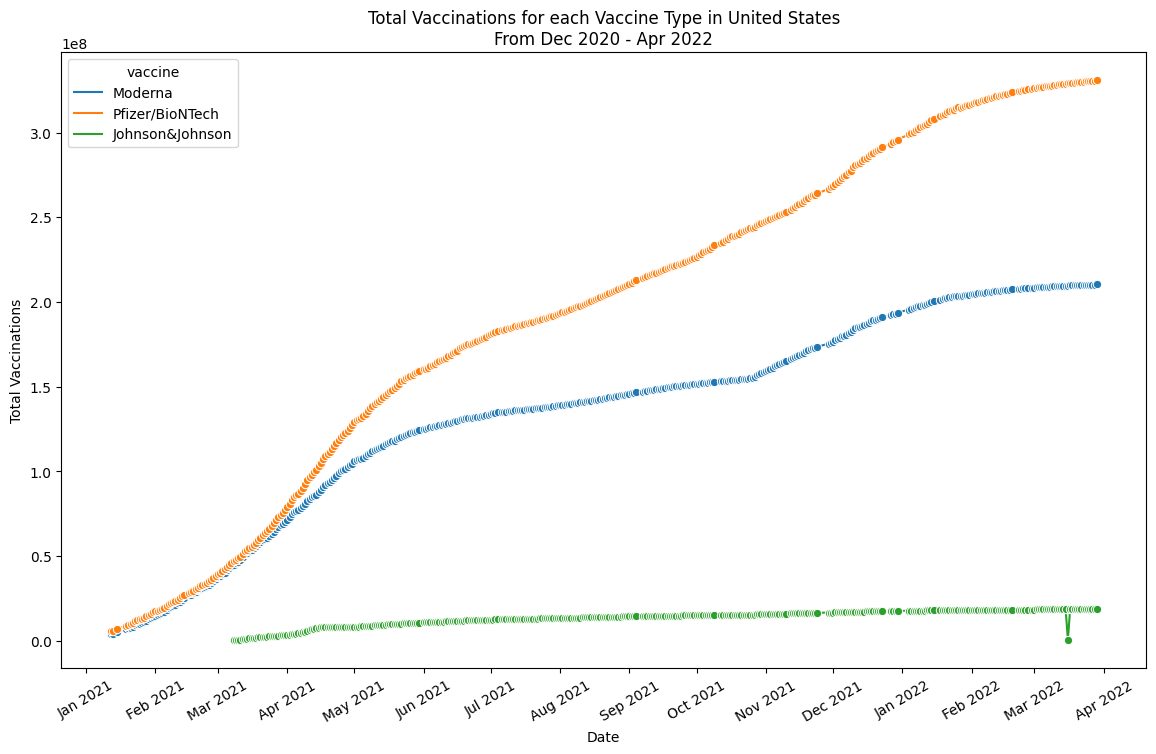

In [116]:
fig, ax = plt.subplots(figsize=(14, 8))  

sns.lineplot(data = country_vac_manuf[country_vac_manuf.location == 'United States']
                ,x = 'date'
                ,y = 'total_vaccinations'
                ,hue ='vaccine'
                ,ci = None
                ,marker='o'
           )

#plt.xticks(rotation=0)

# Create custom ticks using matplotlib date tick locator and formatter
loc = MonthLocator(interval=1)
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))

plt.xlabel('Date')
plt.ylabel('Total Vaccinations')
plt.title("Total Vaccinations for each Vaccine Type in United States\nFrom Dec 2020 - Apr 2022")

plt.xticks(rotation=30)

plt.show()

We can see from the graph that `Pfizer/BioNTech` is the most administered vaccine in USA.After that `Moderna` and `Johnson&Johnson` are in second and third place respectively.

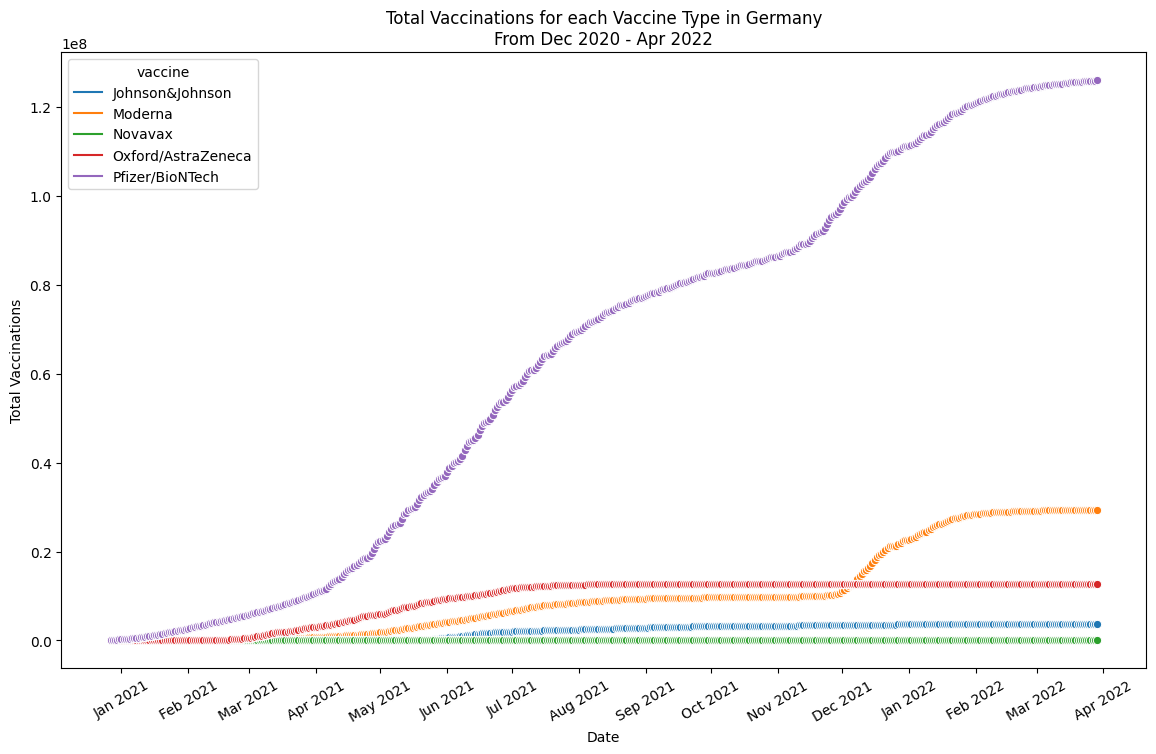

In [117]:
fig, ax = plt.subplots(figsize=(14, 8))  

sns.lineplot(data = country_vac_manuf[country_vac_manuf.location == 'Germany']
                ,x = 'date'
                ,y = 'total_vaccinations'
                ,hue ='vaccine'
                ,ci = None
                ,marker='o'
           )

# Create custom ticks using matplotlib date tick locator and formatter
loc = MonthLocator(interval=1)
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))

plt.xlabel('Date')
plt.ylabel('Total Vaccinations')
plt.title("Total Vaccinations for each Vaccine Type in Germany\nFrom Dec 2020 - Apr 2022")

plt.xticks(rotation=30)

plt.show()

This chart shows cumulative COVID-19 vaccination counts in Germany for five vaccine types from December 2020 through April 2022. `Pfizer/BioNTech` maintained a clear lead throughout the entire vaccination campaign, starting strong in early 2021 and widening the gap over time. `Oxford/AstraZeneca` grew rapidly early in 2021 and was the second-most used vaccine up to approximately December 2021; after that point `Moderna`’s cumulative total surpassed `AstraZeneca` and held second place through April 2022. `Johnson & Johnson` and `Novavax` rank fourth and fifth, respectively, by the end of the period. `Johnson & Johnson` remained in fourth place with limited growth, while `Novavax` — introduced later in the campaign — had the smallest share by the end of April 2022

In [118]:
series = country_vac_manuf.groupby(['date', 'vaccine'])['total_vaccinations'].sum()

series = series.reset_index()

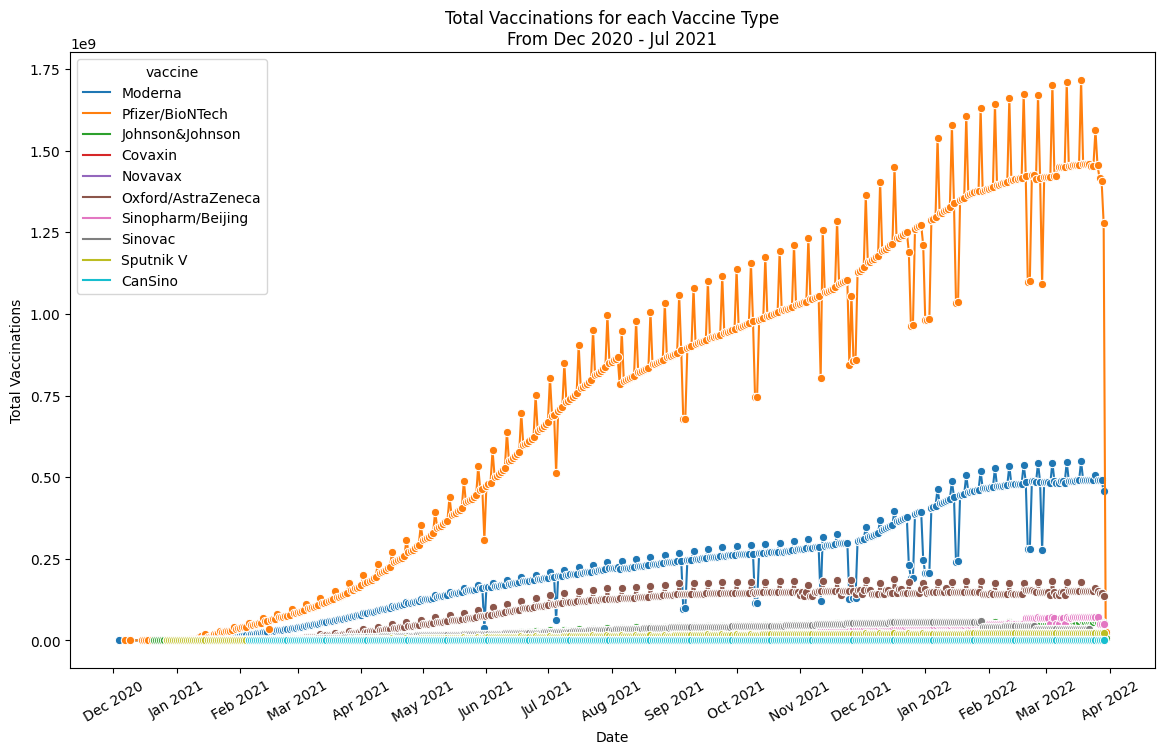

In [119]:
fig, ax = plt.subplots(figsize=(14, 8))

sns.lineplot(data = series
                ,x = 'date'
                ,y = 'total_vaccinations'
                ,hue = 'vaccine'
                ,ci = None
                ,marker='o'
           )

# Create custom ticks using matplotlib date tick locator and formatter
loc = MonthLocator(interval=1)
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))

plt.xlabel('Date')
plt.ylabel('Total Vaccinations')
plt.title("Total Vaccinations for each Vaccine Type\nFrom Dec 2020 - Jul 2021")
plt.xticks(rotation=30)

plt.show()

The line graph shows that the number of injections of `Pfizer/BioNTech` and `Moderna` vaccines increased at a faster rate and these two vaccines are more popular than others.


## Data Preprocessing

Since we are supposed to predict the target values, we have to delete the records with missing values in the target variable(`total_vaccinations`).

In [102]:
df_clean = df.dropna(subset= ['total_vaccinations'])

I used interpolation to fill the null values.

In [103]:
# to interpolate the missing values

df_clean = df_clean.interpolate(method ='linear', limit_direction ='forward')

df_clean = df_clean.interpolate(method ='linear', limit_direction ='backward')

print(df_clean.isna().sum())

country                                0
iso_code                               0
date                                   0
total_vaccinations                     0
people_vaccinated                      0
people_fully_vaccinated                0
daily_vaccinations_raw                 0
daily_vaccinations                     0
total_vaccinations_per_hundred         0
people_vaccinated_per_hundred          0
people_fully_vaccinated_per_hundred    0
daily_vaccinations_per_million         0
vaccines                               0
source_name                            0
source_website                         0
Day                                    0
Month                                  0
Year                                   0
dtype: int64


Now lets convert categorical variable(`country`) to numerical variable by using One-Hot Encoding.

In [104]:
df_clean = pd.get_dummies(df_clean, columns= ['country'], drop_first =True)

# Delete unimportant columns
#df_clean.drop(["iso_code", "date", "daily_vaccinations_raw", "total_vaccinations_per_hundred", "people_fully_vaccinated_per_hundred"
#           ,"vaccines", "source_name", "source_website"], axis=1, inplace=True)

df_clean.drop(["iso_code", "date", "vaccines", "source_name", "source_website"], axis=1, inplace=True)

In [105]:
#Y is the target column, X has the features
X = df_clean.drop(["total_vaccinations"], axis=1)

#X = X.values
y = df_clean['total_vaccinations'].values

## Prepare Data for Machine learning

Now we split the data into training set and test set and standardize the data to put all columns in the same scale.

In [106]:
#Split the data into training set and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

Scaler = StandardScaler()

X_train_scaled  = Scaler.fit_transform(X_train)
X_test_scaled  = Scaler.transform(X_test)

## Train and test your model

### Linear Regression

In [107]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression()

In [108]:
# make predictions
y_pred = lr.predict(X_test_scaled)

# evaluate predictions
acc = r2_score(y_test, y_pred)
#acc = mlr.score(X_test, y_test)
print('R-squared: %.3f' % acc)

mae = mean_absolute_error(y_test, y_pred)
print('MAE: %.3f' % mae)

mse = mean_squared_error(y_test, y_pred)
print('MSE: %.3f' % mse)

rmse =mse**(0.5)

print('RMSE: %.3f' % rmse)

R-squared: 0.954
MAE: 9020599.225
MSE: 2452656802789466.500
RMSE: 49524305.172


### Random Forest Regression

In [113]:
# Fitting Random Forest Regression to the dataset 
# create regressor object
RF_model = RandomForestRegressor(n_estimators=200,
                                  random_state=42)

# fit the regressor with x and y data
RF_model.fit(X_train_scaled, y_train)

y_pred = RF_model.predict(X_test_scaled)

# evaluate predictions
acc = r2_score(y_test, y_pred)

print('R-squared: %.3f' % acc)

mae = mean_absolute_error(y_test, y_pred)
print('MAE: %.3f' % mae)

mse = mean_squared_error(y_test, y_pred)
print('MSE: %.3f' % mse)

rmse =mse**(0.5)
#rmse = sqrt(mse)

print('RMSE: %.3f' % rmse)

R-squared: 0.996
MAE: 638125.686
MSE: 207725498151843.938
RMSE: 14412685.321


### K-Nearest Neighbors Regression

In [114]:
knn_model = KNeighborsRegressor(n_neighbors=3)

knn_model.fit(X_train_scaled, y_train)

KNeighborsRegressor(n_neighbors=3)

In [115]:
y_pred = knn_model.predict(X_test_scaled)

# evaluate predictions
acc = r2_score(y_test, y_pred)

print('R-squared: %.3f' % acc)

mae = mean_absolute_error(y_test, y_pred)
print('MAE: %.3f' % mae)

mse = mean_squared_error(y_test, y_pred)
print('MSE: %.3f' % mse)

rmse =mse**(0.5)
#rmse = sqrt(mse)

print('RMSE: %.3f' % rmse)

R-squared: 0.998
MAE: 1108537.492
MSE: 123672539257411.297
RMSE: 11120815.584


### XGBoost 

In [11]:
param_grid ={ 'n_estimators':[50,100,250,300],
              'colsample_bytree':[0.5, 0.7, 0.9],
              'subsample':[0.5, 0.7, 0.9],
              'max_depth': [1, 3, 5, 6, 8, 10],
              'learning_rate':[0.01, 0.03, 0.1, 0.15, 0.2, 0.5]}

xgbModel = XGBRegressor()
#neg_mean_absolute_error, neg_mean_squared_error
xgb_cv = GridSearchCV(xgbModel, param_grid = param_grid, cv = 10, scoring='neg_mean_squared_error')

xgb_cv.fit(X_train_scaled, y_train)

# Print the tuned parameters and score
print("Tuned XGBoost Regressor Parameters: {}".format(xgb_cv.best_params_))
print("Best score is {}".format(xgb_cv.best_score_))

Tuned XGBoost Regressor Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.15, 'max_depth': 8, 'n_estimators': 300, 'subsample': 0.5}
Best score is -7568995689670.565


In [13]:
xgb_best_model = xgb_cv.best_estimator_

xgb_best_model.fit(X_train_scaled, y_train)

y_pred = xgb_best_model.predict(X_test_scaled)

# evaluate predictions
acc = r2_score(y_test, y_pred)

print('R-squared: %.3f' % acc)

mae = mean_absolute_error(y_test, y_pred)
print('MAE: %.3f' % mae)

mse = mean_squared_error(y_test, y_pred)
print('MSE: %.3f' % mse)

rmse =mse**(0.5)
#rmse = sqrt(mse)

print('RMSE: %.3f' % rmse)

R-squared: 0.999
MAE: 266832.490
MSE: 5406903915476.232
RMSE: 2325275.019


## Save your final model

In [112]:
import pickle 
  
# Save the trained model as a pickle string. 
saved_model = pickle.dumps(RF_model) 
  
# Load the pickled model 
final_model_from_pickle = pickle.loads(saved_model) 
  
# Use the loaded pickled model to make predictions 
final_model_from_pickle.predict(X_test_scaled)

array([1.13106815e+08, 2.70483743e+07, 3.49060462e+07, ...,
       2.26140788e+06, 8.38297940e+05, 1.61169690e+05])

## Conclusions

- `daily_vaccinations` and `daily_vaccinations_raw`are highly correlated.

- `total_vaccinations_per_hundred`, `people_vaccinated_per_hundred` and `people_fully_vaccinated_per_hundred` are highly correlated.
- China, India and US has the highest total number of vaccinations
- Pitcairn Islands has the lowest total number of vaccinations(94).
- Gibraltar has the highest ratio (in percent) between vaccination number and total population
- Most of the countries with low ratio of corona vaccinations to the population are located in Africa
- Burundi has the lowest percentage of vaccinations(0.1 percent)
- Burundi has the highest ratio between population fully immunized and total population
- Burundi has the lowest percentage of population fully immunized.
- Most of the countries with low ratio of population fully immunized to total population are located in Africa
- Iran's vaccinations began in February 2021 and the number of Iran's daily vaccinations peaked at 1225502 in September 2021.
- Iran's total number of vaccinations reached to reached to 140 millions in April 2022
- We can see that there are multiple gaps between the injections of the Covid-19 vaccines in Iran
- During this period 67 percent of Iranians were fully vaccinated
- Vaccinations in the United States began in December of 2020 and in july 2021 total population of USA were vaccinated
- During this period near half of US population(160 millions) were fully vaccinated
- `Pfizer/BioNTech` is the most administered vaccine with 33 millions of total vaccinations.After that `Moderna` and `Oxford/AstraZeneca` are on second and third place.
- `Covaxin` is the least administered vaccine
- Pfizer/BioNTech is the most administered vaccine in USA.After that Moderna and Johnson&Johnson are in second and third place respectively